# W51CA3 2DGaussian Fitting PBCOR

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u
from astropy.io import fits
import radio_beam
from radio_beam import Beam
import pandas as pd
from astropy.wcs import WCS

/Users/galagabits/miniconda3/envs/masers/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
channel = None

if channel is not None:
    print('working')

In [ ]:
from astropy.io import fits

filename = "/Volumes/GalagaResearch/Developer/masers/continuum/VLA_continuum/W51_North_KabandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal2.image.tt0.pbcor_ICRS.fits"
hdul = fits.open(filename)

data_cube = hdul[0].data

if data_cube.ndim == 4:
    data_cube = data_cube[0, 0, :, :]

print("Data shape:", data_cube.shape)

Data shape: (10000, 10000)


<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (290.9159074, 14.51800555)>


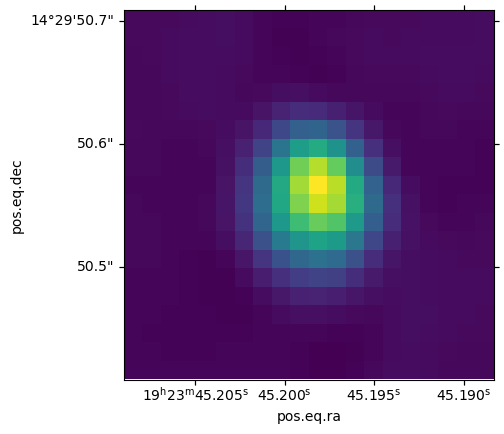

In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.wcs.utils import pixel_to_skycoord

directory3 = '/Volumes/GalagaResearch/Developer/masers/continuum/originals/ICRS/W51_North_KabandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal2.image.tt0.pbcor.fits'

hdul = fits.open(directory3)
hdu = hdul[0]
ww = WCS(hdu.header)

data_cube = hdul[0].data

x, y = 5219, 4960
size = 10
cube_cutout = data_cube[0,0, y - size:y + size, x - size:x + size]

norm = ImageNormalize(cube_cutout, interval=ZScaleInterval())

plt.subplot(projection=ww.celestial)
plt.imshow(cube_cutout, origin='lower')

sky_coord = pixel_to_skycoord(x, y, ww)

# Print result
print(sky_coord)

<SkyCoord (ICRS): (ra, dec) in deg
    (290.9159074, 14.51800555)>


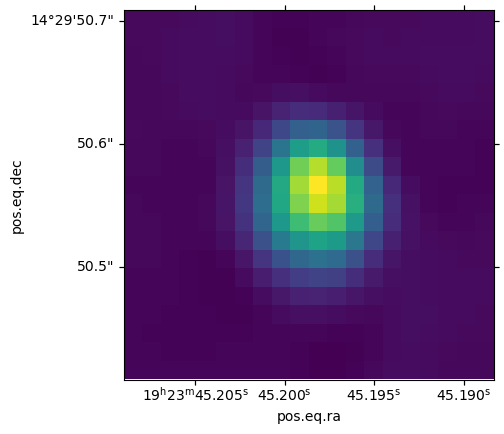

In [7]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.wcs.utils import pixel_to_skycoord

directory5 = '/Volumes/GalagaResearch/Developer/masers/continuum/originals/ICRS/W51_North_KabandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal2.image.tt0.pbcor_ICRS.fits'

hdul = fits.open(directory5)
hdu = hdul[0]
ww = WCS(hdu.header)

data_cube = hdul[0].data

x, y = 5219, 4960
size = 10
cube_cutout = data_cube[0,0,y - size:y + size, x - size:x + size]

norm = ImageNormalize(cube_cutout, interval=ZScaleInterval())

plt.subplot(projection=ww.celestial)
plt.imshow(cube_cutout, origin='lower')

sky_coord = pixel_to_skycoord(x, y, ww)

# Print result
print(sky_coord)

In [6]:
#Accessing Cube Data
def fit_2dgaussian(directory, maser_table, freq, amplitude, x, y, x_stddev, y_stddev, theta=np.pi/3, size=13, channel=0, cube=True, format='fits', table=True):

    if cube:
        
        cube = SpectralCube.read(directory, format=format)

        if channel is None:
            pass
        else:
            cube = cube[channel,:,:]

        cube_cutout = cube[y - size:y + size, x - size:x + size]
        yy, xx = cube_cutout.spatial_coordinate_map

        cord = cube.world[y,x]

        x_guess, y_guess = cord[1], cord[0]

    else:
        
        hdul = fits.open(directory)

        hdu = hdul[0]

        data_cube = hdul[0].data

        if data_cube.ndim == 4:
            data = data_cube[0, 0, :, :] * u.Jy/u.beam

        else:
            data = hdu.data * u.Jy/u.beam

        header = hdu.header

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            ww = WCS(header).celestial

        data_cutout = data[y - size:y + size, x - size:x + size]
        ypixel_grid, xpixel_grid = np.mgrid[y - size:y + size, x - size:x + size]
        
        xx, yy = ww.pixel_to_world_values(xpixel_grid, ypixel_grid)

        xx = (xx * u.deg)
        yy = (yy * u.deg)

        x_guess, y_guess = xx[size, size], yy[size, size]

        cube_cutout = data_cutout


    p_init_gauss2D = models.Gaussian2D(x_mean=x_guess, y_mean=y_guess, amplitude=amplitude * (u.Jy/u.beam),
                                    x_stddev=(x_stddev), y_stddev=(y_stddev), theta=(theta)*u.rad)

    fit_p = fitting.LevMarLSQFitter()

    cube_cutout_quant = cube_cutout

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)

    p_init_gauss2D.theta.fixed = True

    cov = np.diag(fit_p.fit_info['param_cov'])
    errors = np.sqrt(cov)

    amplitude_error=np.format_float_scientific(errors[0],precision=9)
    x_mean_error=np.format_float_scientific(errors[1],precision=9)
    y_mean_error=np.format_float_scientific(errors[2],precision=9)
    x_stddev_error=np.format_float_scientific(errors[3],precision=9)
    y_stddev_error=np.format_float_scientific(errors[4],precision=9)
    theta_error=np.format_float_scientific(errors[5],precision=9)

    amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
    x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
    y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
    x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
    y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
    theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)

                
    plt.figure(figsize=(20, 6))
    plt.suptitle(f"Source-CA3 freq-{freq}", fontsize=18)

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Model")
    plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("Residual")
    plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
    plt.colorbar(label='S (Jy)')

    plt.show()

    #saveplotfig_gaussianfit()

    print("Parameter" + ' ' + 'Error' +"\n")
    print(amplitude + ' ' + amplitude_error +"\n")
    print(x_mean + ' ' + x_mean_error +"\n")
    print(y_mean + ' ' + y_mean_error +"\n")
    print(x_stddev + ' ' + x_stddev_error +"\n")
    print(y_stddev + ' ' + y_stddev_error +"\n")
    print(theta + ' ' + theta_error +"\n")
    
    if table:
        new_row = pd.DataFrame({'freq': [freq], 'x_pix': [x], 'y_pix': [y], 'amplitude': [amplitude], 'amplitude_error': [amplitude_error], 'x_mean': [x_mean], 'x_mean_error': [x_mean_error], 'y_mean': [y_mean], 'y_mean_error': [y_mean_error]})
        maser_table = pd.concat([maser_table, new_row], ignore_index=True)

        return maser_table

#### ALMA Band 6 (1 mm = 226 GHz) continuum
`/orange/adamginsburg/w51/FITS/W51n_cont_briggsSC_tclean.image.fits`

In [7]:
ca3_positions = pd.DataFrame(columns=['freq', 'x_pix', 'y_pix', 'amplitude', 'amplitude_error', 'x_mean', 'x_mean_error', 'y_mean', 'y_mean_error'])

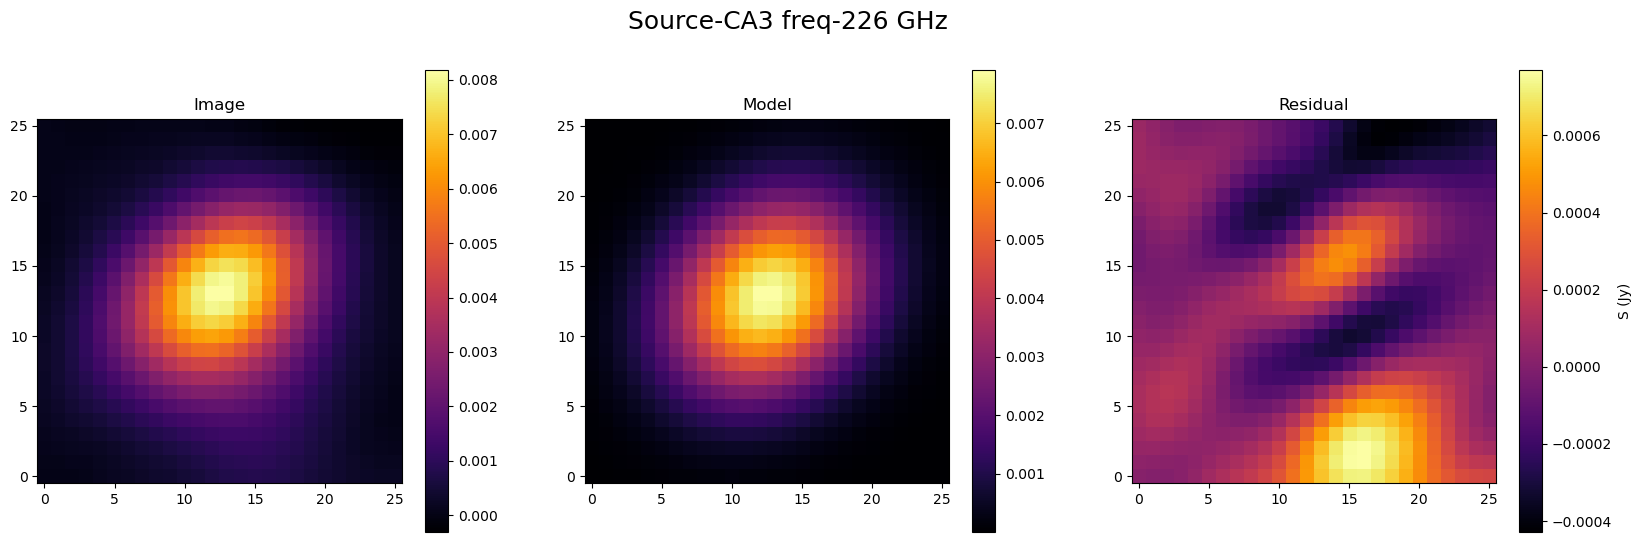

Parameter Error

7.949175318e-03 2.537724793e-04

2.90917076e+02 1.224428806e-07

1.45182376e+01 1.211903921e-07

3.577235902e-06 1.176348935e-07

4.368343544e-06 1.261432863e-07

9.161601524e-01 3.332209784e-01



In [5]:
directory1 = '/Volumes/GalagaResearch/Developer/masers/continuum/W51n_cont_briggsSC_tclean.image.fits'

ca3_positions = fit_2dgaussian(table=True, cube=True, directory=directory1, 
                                          maser_table=ca3_positions,
                                          amplitude=0.03, x=3295, y=3580, x_stddev=0.039999996 * u.arcsec, y_stddev=0.039999996 * u.arcsec, theta=1.5, 
                                          size=13, freq='226 GHz')

#### ALMA Band 3 (3mm) continuum

`/orange/adamginsburg/w51/2017.1.00293.S/may2021_successful_imaging/w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor`

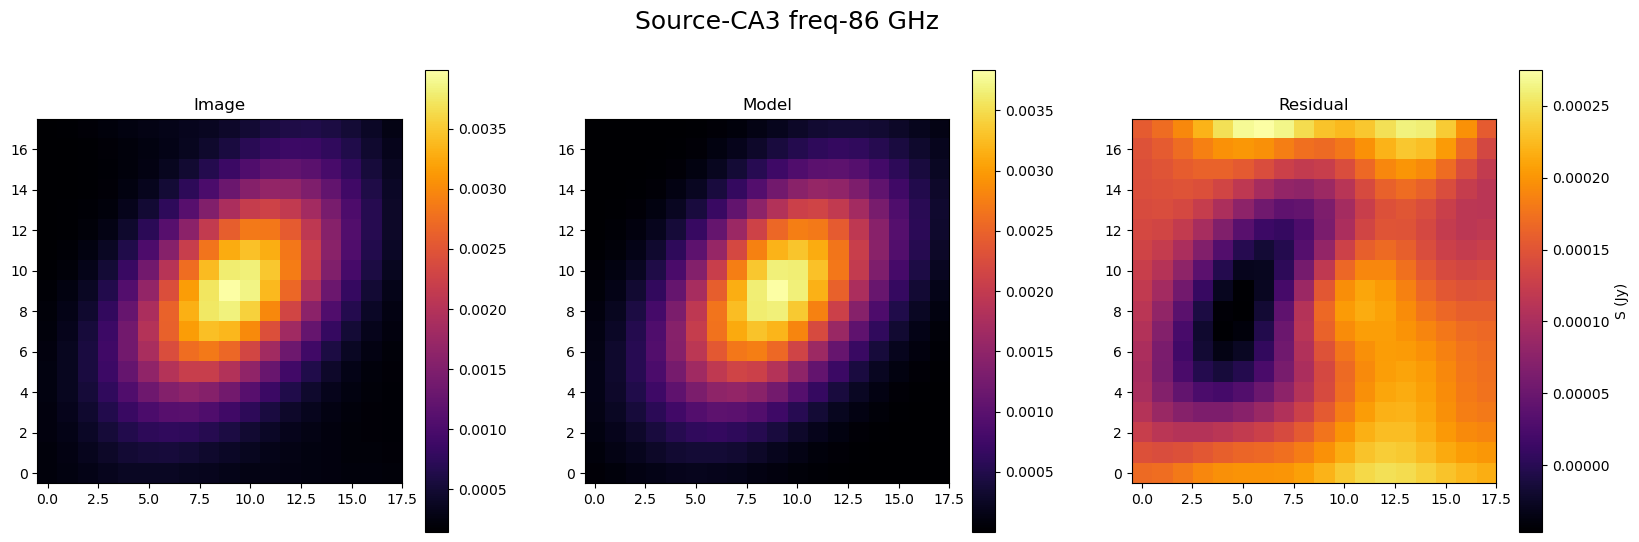

Parameter Error

3.836216067e-03 1.892479932e-04

2.909170744e+02 4.487728700e-08

1.451823445e+01 4.491885880e-08

5.327426279e-06 3.324315678e-08

8.670556178e-06 5.523993741e-08

7.804190851e-01 8.853283474e-03



In [6]:
directory1 = '/Volumes/GalagaResearch/Developer/masers/continuum/w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'

ca3_positions = fit_2dgaussian(table=True, format='fits', cube=True, directory=directory1,
                                          maser_table=ca3_positions,
                                          amplitude=0.03, x=7047, y=7342, x_stddev=0.019 * u.arcsec, y_stddev=0.031 * u.arcsec, theta=np.pi/4, 
                                          size=9, freq='86 GHz')

#### VLA Q-band (0.7 cm = 46.99 GHz) continuum ICRS
`/orange/adamginsburg/w51/vla/19A-254/blue_imaging/W51_North_QbandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal4_final.image.tt0.pbcor.fits`

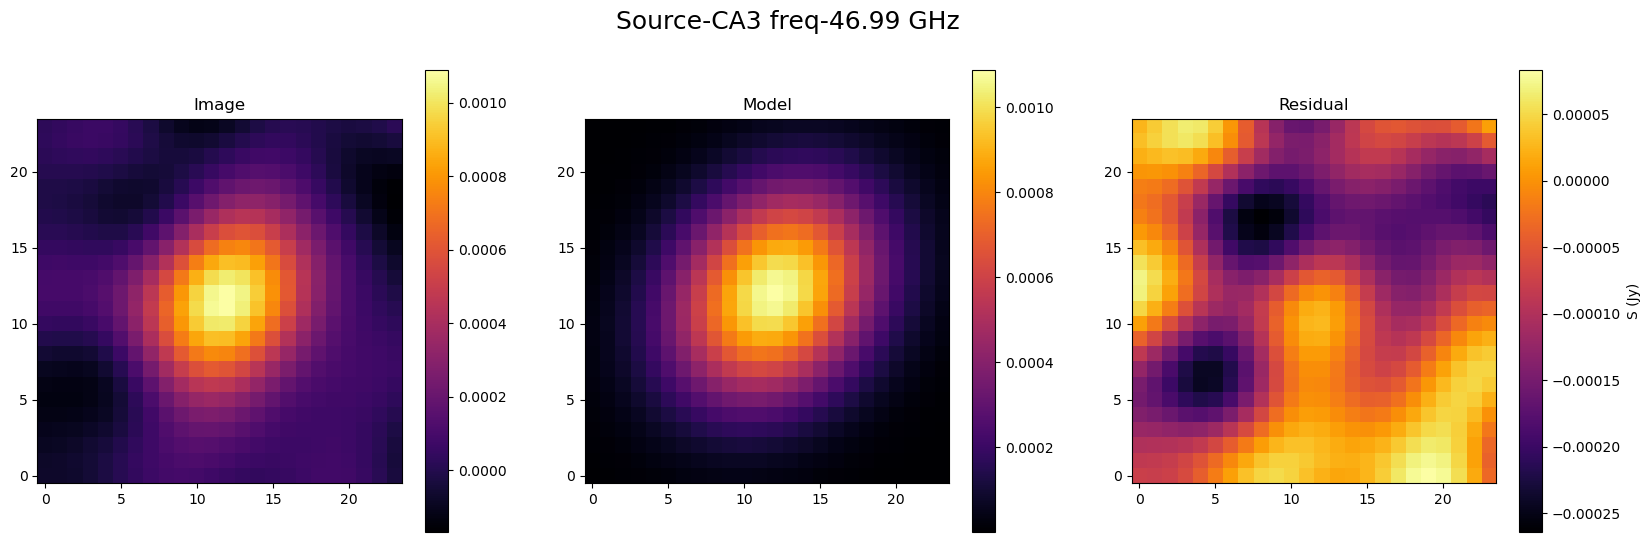

Parameter Error

1.0874127e-03 1.123486631e-04

2.909170724e+02 7.349999355e-10

1.451823333e+01 7.355606616e-10

5.832473193e-06 6.562175799e-10

7.220523623e-06 8.173703473e-10

7.851959800e-01 3.724210115e-04



In [14]:
directory3 = '/Volumes/GalagaResearch/Developer/masers/continuum/VLA_continuum/W51_North_QbandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal4_final.image.tt0.pbcor.fits'

ca3_positions = fit_2dgaussian(table=True, cube=False, directory=directory3, 
                                          maser_table=ca3_positions,
                                          amplitude=1, x=7345, y=7544, x_stddev=0.021 * u.arcsec, y_stddev=0.026 * u.arcsec, theta=np.pi/4, 
                                          size=12, freq='46.99 GHz')

#### VLA Ka-band ( 1 cm =  GHz) continuum ICRS
`/orange/adamginsburg/w51/vla/19A-254/derod/W51_North_KabandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal2.image.tt0.pbcor.fits`

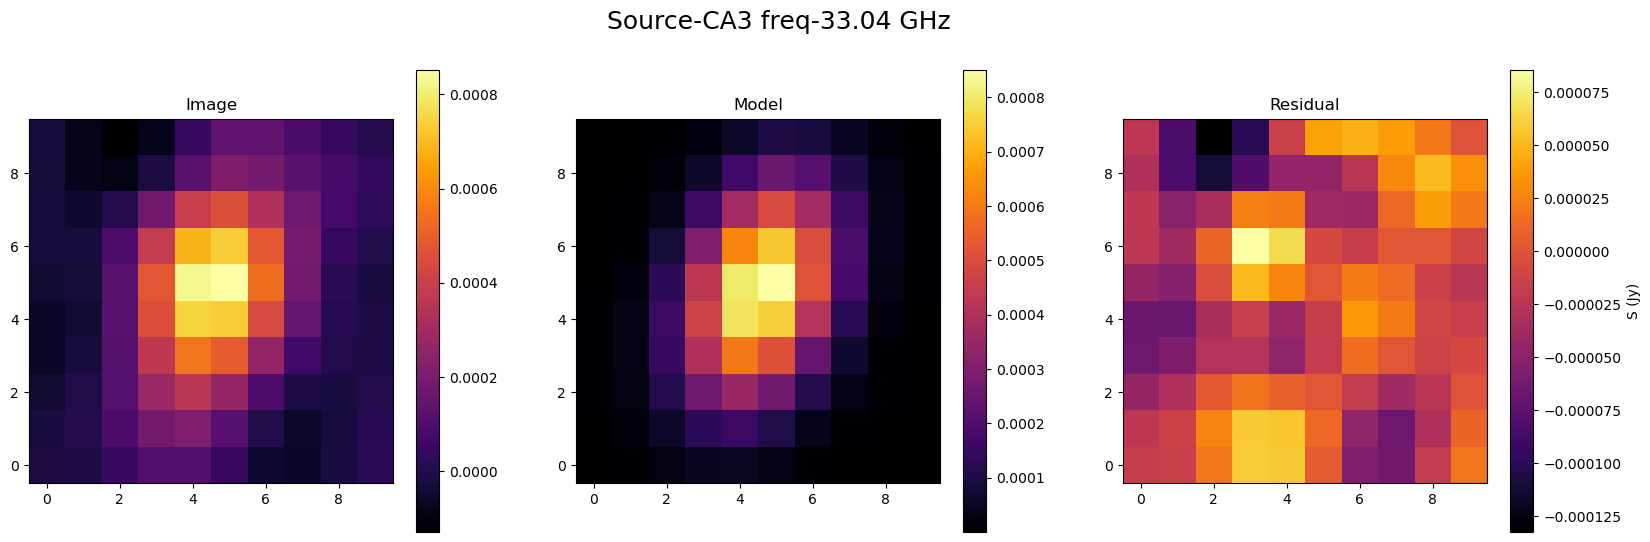

Parameter Error

8.930578327e-04 1.013525269e-04

2.909170714e+02 6.855466515e-07

1.451823383e+01 9.664812407e-07

8.777530935e-06 1.013606588e-06

5.535689575e-06 6.413065144e-07

1.908096523e+00 1.789684553e-01



In [8]:
directory3 = '/Volumes/GalagaResearch/Developer/masers/continuum/originals/W51_North_KabandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal2.image.tt0.pbcor.fits'

ca3_positions = fit_2dgaussian(table=True, cube=False, directory=directory3, 
                                          maser_table=ca3_positions,
                                          amplitude=0.03, x=4949, y=5015, x_stddev=1.111111e-5 * u.degree, y_stddev=1.111111e-5 * u.degree, theta=1.5, 
                                          size=5, freq='33.04 GHz')

In [9]:
ca3_positions

,freq,x_pix,y_pix,amplitude,amplitude_error,x_mean,x_mean_error,y_mean,y_mean_error
0,33.04 GHz,4949,5015,8.930578327e-04,1.013525269e-04,2.909170714e+02,6.855466515e-07,1.451823383e+01,9.664812407e-07


In [10]:
ca3_positions_ICRS = pd.DataFrame(columns=['freq', 'x_pix', 'y_pix', 'amplitude', 'amplitude_error', 'x_mean', 'x_mean_error', 'y_mean', 'y_mean_error'])

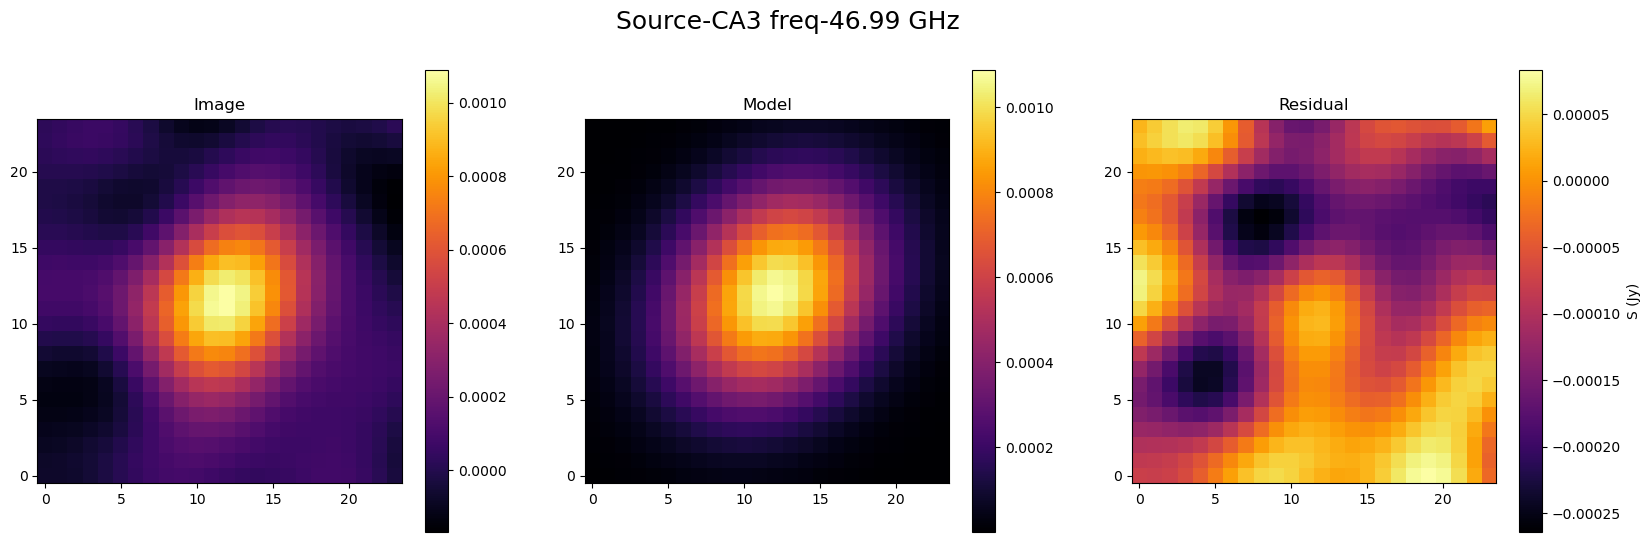

Parameter Error

1.0874127e-03 1.123486631e-04

2.909170724e+02 7.349999355e-10

1.451823333e+01 7.355606616e-10

5.832473193e-06 6.562175799e-10

7.220523623e-06 8.173703473e-10

7.851959800e-01 3.724210115e-04



In [27]:
directory3 = '/Volumes/GalagaResearch/Developer/masers/continuum/VLA_continuum/W51_North_QbandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal4_final.image.tt0.pbcor_ICRS.fits'

ca3_positions_ICRS = fit_2dgaussian(table=True, cube=False, directory=directory3, 
                                          maser_table=ca3_positions_ICRS,
                                          amplitude=1, x=7345, y=7544, x_stddev=0.021 * u.arcsec, y_stddev=0.026 * u.arcsec, theta=np.pi/4, 
                                          size=12, freq='46.99 GHz')

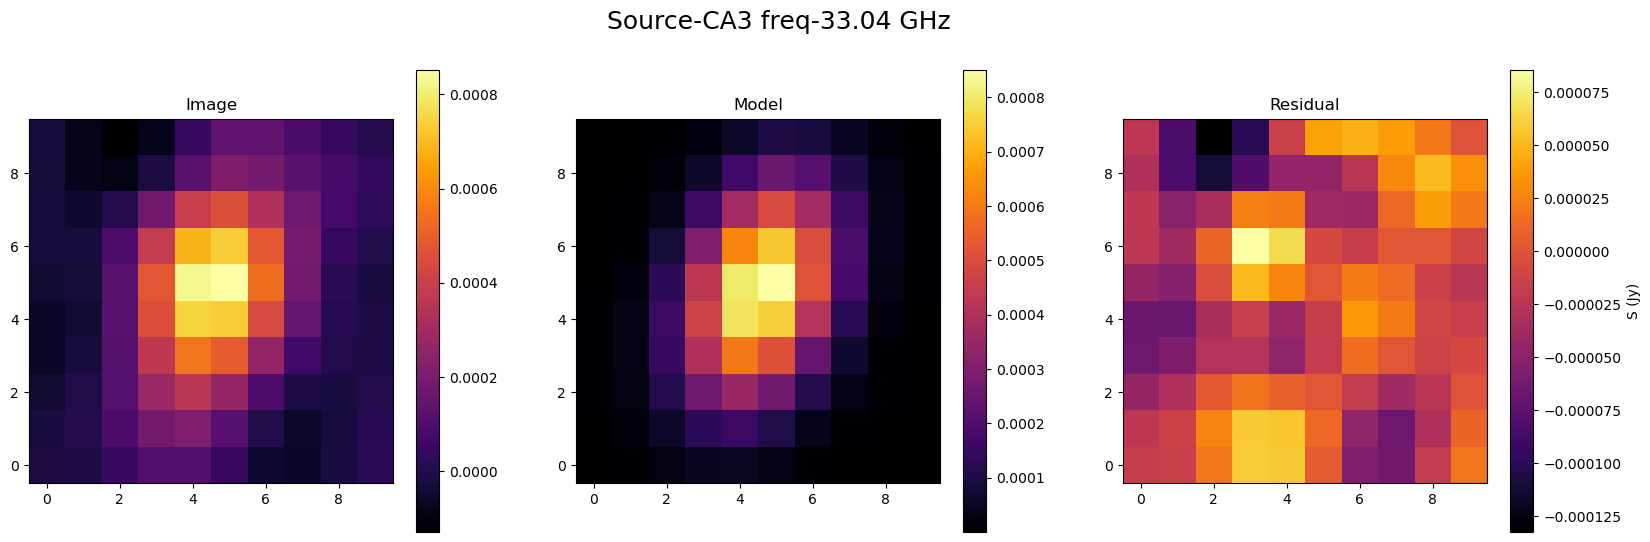

Parameter Error

8.930578327e-04 1.013525269e-04

2.909170714e+02 6.855466515e-07

1.451823383e+01 9.664812407e-07

8.777530935e-06 1.013606588e-06

5.535689575e-06 6.413065144e-07

1.908096523e+00 1.789684553e-01



In [11]:
directory3 = '/Volumes/GalagaResearch/Developer/masers/continuum/originals/ICRS/W51_North_KabandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal2.image.tt0.pbcor_ICRS.fits'

ca3_positions_ICRS = fit_2dgaussian(table=True, cube=False, directory=directory3, 
                                          maser_table=ca3_positions_ICRS,
                                          amplitude=0.03, x=4949, y=5015, x_stddev=1.111111e-5 * u.degree, y_stddev=1.111111e-5 * u.degree, theta=1.5, 
                                          size=5, freq='33.04 GHz')

In [12]:
ca3_positions

,freq,x_pix,y_pix,amplitude,amplitude_error,x_mean,x_mean_error,y_mean,y_mean_error
0,33.04 GHz,4949,5015,8.930578327e-04,1.013525269e-04,2.909170714e+02,6.855466515e-07,1.451823383e+01,9.664812407e-07


In [13]:
ca3_positions_ICRS

,freq,x_pix,y_pix,amplitude,amplitude_error,x_mean,x_mean_error,y_mean,y_mean_error
0,33.04 GHz,4949,5015,8.930578327e-04,1.013525269e-04,2.909170714e+02,6.855466515e-07,1.451823383e+01,9.664812407e-07


In [14]:
float(ca3_positions_ICRS.loc[ca3_positions_ICRS['freq'] == '33.04 GHz']['x_mean'].values[0]) - float(ca3_positions.loc[ca3_positions['freq'] == '33.04 GHz']['x_mean'].values[0])

0.0

In [12]:
float(ca3_positions_ICRS.loc[ca3_positions_ICRS['freq'] == '46.99 GHz']['x_mean'].values[0]) - float(ca3_positions.loc[ca3_positions['freq'] == '46.99 GHz']['x_mean'].values[0])

IndexError: index 0 is out of bounds for axis 0 with size 0